# Train a model on features engineered from Pull Requests data


## What we did previously

In the previous [notebook](./02_feature_engineering.ipynb) we explored the various fields in the PR dataset and derived some features from them in order to frame an a Machine Learning where we predict the time taken to merge a PR.

## In this step

In this notebook, we will first create transformer objects (based on the feature explorations in the previous notebook) to extract features from raw PR data. Then, we will train machine learning models to classify a PR's `time_to_merge` into one of the above 10 bins (or "classes").

In [1]:
import os
import gzip
import json
import boto3
import tempfile

import joblib
import warnings
from io import BytesIO
from copy import deepcopy

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from dotenv import load_dotenv, find_dotenv

from src.features.build_features import (
    DateTimeDetailsTransformer,
    NumChangedFilesTransformer,
    StringLenTransformer,
    FileTypeCountTransformer,
    TitleWordCountTransformer,
)

warnings.filterwarnings("ignore")
load_dotenv(find_dotenv(), override=True)

True

In [2]:
class CephCommunication:
    """
    Class to establish communication with a ceph s3 bucket.
    It connects with the bucket and provides methods to read and write data in the parquet format.
    """

    def __init__(
        self, s3_endpoint_url, aws_access_key_id, aws_secret_access_key, s3_bucket
    ):
        self.s3_endpoint_url = s3_endpoint_url
        self.aws_access_key_id = aws_access_key_id
        self.aws_secret_access_key = aws_secret_access_key
        self.s3_resource = boto3.resource(
            "s3",
            endpoint_url=self.s3_endpoint_url,
            aws_access_key_id=self.aws_access_key_id,
            aws_secret_access_key=self.aws_secret_access_key,
        )
        self.bucket = s3_bucket
        ## Todo: Add try catch

    def upload_to_ceph(self, dataframe, s3_path, filename):
        """
        This helper function takes as input the data frame to be uploaded, and the output filename.
        It then saves the data frame in the defined ceph bucket.
        """
        parquet_buffer = BytesIO()
        dataframe.to_parquet(parquet_buffer)
        s3_obj = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        status = s3_obj.put(Body=parquet_buffer.getvalue())
        return status

    def read_from_ceph(self, s3_path, filename):
        """
        Helper function to read from ceph and see if the saved data is correct.
        """
        buffer = BytesIO()
        s3_object = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        s3_object.download_fileobj(buffer)
        df_temp = pd.read_parquet(buffer)
        return df_temp

## Get Raw Data

In [3]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,

ORG = os.getenv("GITHUB_ORG")
REPO = os.getenv("GITHUB_REPO")

## S3 bucket credentials
s3_endpoint_url = os.getenv("S3_ENDPOINT_URL")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")

REMOTE = os.getenv("REMOTE")

s3_input_data_path = os.getenv("CEPH_BUCKET_PREFIX")
local_input_data_path = "../../../data/raw/GitHub/PullRequest.json.gz"
local_output_data_path = "../../../data/processed/github"
RAW_DATA_PATH = os.path.join(
    s3_input_data_path, "srcopsmetrics/bot_knowledge", ORG, REPO, "PullRequest.json"
)

CHOSEN_MODEL = os.getenv("CHOSEN_MODEL")

In [4]:
output = []
if REMOTE:
    print("getting dataset from ceph")
    s3 = boto3.resource(
        "s3",
        endpoint_url=s3_endpoint_url,
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
    )
    content = s3.Object(s3_bucket, RAW_DATA_PATH)
    file = content.get()["Body"].read().decode("utf-8")

    prs = json.loads(file)

    for pr in prs.splitlines():
        output.append(json.loads(pr))

else:
    print("getting dataset from local")
    with gzip.open(local_input_data_path, "r") as f:
        prs = json.loads(f.read().decode("utf-8"))


pr_df = pd.DataFrame(output)

getting dataset from ceph


## Extract Labels from Raw Data

In [5]:
y = (pr_df["merged_at"] - pr_df["created_at"]).astype("float")
y = y.dropna()
y

0          756.0
2      1888847.0
3         2731.0
4         1340.0
5          871.0
         ...    
410    1890777.0
411    1177800.0
412     488406.0
413    2159397.0
415        382.0
Length: 384, dtype: float64

In [6]:
n_buckets = 10

quantiles = y.quantile(q=np.arange(0, 1 + 1e-100, 1 / n_buckets))
quantiles

0.0         7.0
0.1        37.3
0.2       118.6
0.3       136.0
0.4       260.2
0.5       607.5
0.6      1228.6
0.7      5008.4
0.8     71007.0
0.9    434048.3
dtype: float64

In [7]:
def get_ttm_class(ttm):

    for rownum, (indx, val) in enumerate(quantiles.iteritems()):
        if ttm < val:
            return rownum - 1
    return 9


y = y.apply(get_ttm_class)
y

0      5
2      9
3      6
4      6
5      5
      ..
410    9
411    9
412    9
413    9
415    4
Length: 384, dtype: int64

## Extract Features from Raw Data

In this section, we will create transformer objects to process raw data as per the feature extraction methods that were found to be the most effective in the previous EDA notebook.

To ensure that joblib serializes the custom transformer objects correctly, we will write their definitions in [`src/features/build_features.py`](../../src/features/build_features.py) instead of this notebook, and import them from the `src` package. This way, the `src` package can be listed as a dependency wherever these objects need to be deserialized (for example, Seldon server for model deployment).

#### size

In [8]:
# map values to 0,1,2,3,4,5
pr_size_encoder = OrdinalEncoder(categories=[["XS", "S", "M", "L", "XL", "XXL"]])

#### created_at

In [9]:
# get day, month, date, etc. from a unix timestamp
dt_details_transf = DateTimeDetailsTransformer()

#### changed_files_number

In [10]:
# number of files changed in PR
n_changed_files_transf = NumChangedFilesTransformer()

#### body_size

In [11]:
# number of characters in PR description
body_size_transf = StringLenTransformer("body")

#### filetype_\<type>

In [12]:
# how many files of the given extension were changed in PR
FILETYPE_FEATURES_FILENAME = os.path.join(ORG + REPO + "FILETYPE.parquet")
FILETYPE_FEATURES_KEY = os.path.join(s3_input_data_path, ORG, REPO, "features")
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
filetype_df = cc.read_from_ceph(FILETYPE_FEATURES_KEY, FILETYPE_FEATURES_FILENAME)

In [13]:
filetype_df

,filetype
0,.py
1,.lock
2,.yaml
3,Pipfile
4,.rst
5,OWNERS
6,.toml
7,CODEOWNERS
8,None
9,.png


In [14]:
FILE_EXTENSIONS_TO_COUNT = list(filetype_df["filetype"])

ftype_count_transf = FileTypeCountTransformer(file_extensions=FILE_EXTENSIONS_TO_COUNT)

#### title_wordcount_\<word>

In [15]:
TITLE_FEATURES_FILENAME = os.path.join(ORG + REPO + "titlewords.parquet")
TITLE_FEATURES_KEY = os.path.join(s3_input_data_path, ORG, REPO, "features")
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
title_word_keep_cols_df = cc.read_from_ceph(TITLE_FEATURES_KEY, TITLE_FEATURES_FILENAME)

In [16]:
title_word_keep_cols_df

,title
0,0rc1
1,0rc2
2,0rc3
3,add
4,added
...,...
197,wip
198,workflows
199,xtuchyna
200,yaml


In [17]:
# how many times these words appeared in PR title
WORDS_TO_COUNT = list(title_word_keep_cols_df["title"])

title_wc_transf = TitleWordCountTransformer(words=WORDS_TO_COUNT)

## Apply Transforms

In [18]:
# transformer objects compiled into one columntransformer
raw_data_processor = ColumnTransformer(
    [
        ("pr_size", pr_size_encoder, ["size"]),  # 1 cols generated
        ("created_at_details", dt_details_transf, ["created_at"]),  # 4 cols generated
        (
            "n_changed_files",
            n_changed_files_transf,
            ["changed_files_number"],
        ),  # 1 cols generated
        ("body_size", body_size_transf, ["body"]),  # 1 cols generated
        ("n_commits", "passthrough", ["commits_number"]),  # 1 cols generated
        (
            "filetype_counter",
            ftype_count_transf,
            ["changed_files"],
        ),
        ("title_word_counter", title_wc_transf, ["title"]),
    ],
    remainder="drop",
)

In [19]:
# column names. this is needed because sklearn forcefully converts df to ndarray,
# thus losing column information. this is a hack to retain that info. look for alternatives
cols = (
    [
        "size",
        "created_at_day",
        "created_at_month",
        "created_at_weekday",
        "created_at_hour",
    ]
    + [
        "changed_files_number",
        "body_size",
        "commits_number",
    ]
    + [f"filetype_{f}" for f in FILE_EXTENSIONS_TO_COUNT]
    + [f"title_wordcount_{w}" for w in WORDS_TO_COUNT]
)

In [20]:
X = raw_data_processor.fit_transform(pr_df)
X = pd.DataFrame(X, index=pr_df.index, columns=cols)
X.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,commits_number,filetype_.py,filetype_.lock,...,title_wordcount_var,title_wordcount_version,title_wordcount_visualization,title_wordcount_visualizations,title_wordcount_waiting,title_wordcount_wip,title_wordcount_workflows,title_wordcount_xtuchyna,title_wordcount_yaml,title_wordcount_⬆️
0,2.0,12.0,10.0,2.0,18.0,2.0,468.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,12.0,10.0,2.0,18.0,1.0,74.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,20.0,9.0,1.0,22.0,6.0,124.0,8.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,16.0,9.0,4.0,15.0,1.0,6.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,16.0,9.0,4.0,15.0,1.0,73.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
pr_df

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,id
0,Release of version 2.12.0,"Hey, @xtuchyna!\n\nOpening this PR to create a...",M,khebhut[bot],1665600542,1.665601e+09,sesheta,1.665601e+09,sesheta,1,2,{'sesheta': 327},"{'1139569371': {'author': 'sefkhet-abwy[bot]',...","[approved, bot, size/M, ok-to-test]",[2eadea6d1417c3baede8d3b32ea1cd01c37bb319],"[CHANGELOG.md, srcopsmetrics/__init__.py]",1.665601e+09,1.665601e+09,612
1,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,XL,khebhut[bot],1665600524,NaN,None,NaN,None,1,1,"{'sesheta': 187, 'khebhut[bot]': 6}","{'1139569050': {'author': 'sefkhet-abwy[bot]',...","[approved, bot, size/XL, ok-to-test]",[fcd36e9e238c243c73ca0a214ed373b2cf5c1c35],[Pipfile.lock],1.665601e+09,1.665601e+09,611
2,Mi fixes,## Related Issues and Dependencies\r\nrelated ...,L,Gkrumbach07,1663711269,1.665600e+09,sesheta,1.665600e+09,sesheta,8,6,"{'xtuchyna': 13, 'Gkrumbach07': 24, 'sesheta':...","{'1118375791': {'author': 'xtuchyna', 'words_c...","[approved, size/L]","[29f4ffd578ee20ff379765d7835dc5a306832a3c, 98e...","[srcopsmetrics/cli.py, srcopsmetrics/entities/...",1.663938e+09,1.665600e+09,609
3,Automatic update of base-image in CI,Automatic update of base-image in CI.,XS,sesheta,1663342324,1.663345e+09,sesheta,1.663345e+09,sesheta,1,1,{'sesheta': 140},"{'1110874496': {'author': 'sefkhet-abwy[bot]',...","[approved, size/XS, ok-to-test]",[d5d590ff2a244cb4d2baee2682ee9b982b4b5c19],[.aicoe-ci.yaml],1.663342e+09,1.663342e+09,608
4,Automatic update of dependencies by Kebechet f...,Kebechet has updated the dependencies to the l...,L,khebhut[bot],1663342276,1.663344e+09,sesheta,1.663344e+09,sesheta,1,1,{'sesheta': 397},"{'1110873483': {'author': 'sefkhet-abwy[bot]',...","[approved, size/L, bot, ok-to-test]",[a676faae110a141fb409c6d7cd959d364a8cfe50],[Pipfile.lock],1.663342e+09,1.663342e+09,607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,Feature/expand data collection from prs,## Related Issues and Dependencies\r\n\r\n…\r\...,L,xtuchyna,1576000129,1.577178e+09,None,1.577178e+09,None,6,1,"{'pacospace': 1, 'ghost': 50}","{'330365548': {'author': 'pacospace', 'words_c...","[approved, size/L]","[350b1c92016696cd92bccc96bc1dc067494cbd38, cf6...",[create_bot_knowledge.py],1.576054e+09,1.577178e+09,5
412,Correct typo in CODEOWNERS,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XS,pacospace,1574979066,1.575467e+09,goern,1.575467e+09,goern,1,1,{'ghost': 15},"{'324527213': {'author': 'goern', 'words_count...","[approved, size/XS]",[bae7c611679f19b043d29edbc06dfb88b883154a],[.github/CODEOWNERS],1.575005e+09,1.575005e+09,4
413,refactor code and correct the update knowledge...,## Related Issues and Dependencies\r\n\r\n…\r\...,XXL,xtuchyna,1574441228,1.576601e+09,None,1.576601e+09,None,17,5,"{'ghost': 147, 'goern': 16, 'xtuchyna': 26, 'p...","{'324441775': {'author': 'pacospace', 'words_c...","[size/XXL, approved]","[ea1098bcaa5d614ca63f637f6599d3c1f1a40d89, 719...","[.zuul.yaml, create_bot_knowledge.py, pr_revie...",1.574971e+09,1.576055e+09,3
414,Correct update logic,Signed-off-by: Francesco Murdaca <fmurdaca@red...,XS,pacospace,1574357322,1.574437e+09,pacospace,NaN,None,1,1,"{'ghost': 15, 'pacospace': 59}","{'321156268': {'author': 'goern', 'words_count...","[approved, size/XS]",[ddc04fe9f8dccf877afc4d4a5b68c33cedab707b],[create_bot_knowledge.py],1.574367e+09,1.574367e+09,2


In [22]:
X

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,commits_number,filetype_.py,filetype_.lock,...,title_wordcount_var,title_wordcount_version,title_wordcount_visualization,title_wordcount_visualizations,title_wordcount_waiting,title_wordcount_wip,title_wordcount_workflows,title_wordcount_xtuchyna,title_wordcount_yaml,title_wordcount_⬆️
0,2.0,12.0,10.0,2.0,18.0,2.0,468.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,12.0,10.0,2.0,18.0,1.0,74.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,20.0,9.0,1.0,22.0,6.0,124.0,8.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,16.0,9.0,4.0,15.0,1.0,6.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,16.0,9.0,4.0,15.0,1.0,73.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
411,3.0,10.0,12.0,1.0,17.0,1.0,83.0,6.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
412,0.0,28.0,11.0,3.0,22.0,1.0,17.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
413,5.0,22.0,11.0,4.0,16.0,5.0,77.0,17.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
414,0.0,21.0,11.0,3.0,17.0,1.0,61.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Drop NA + Train/Test Split

In [23]:
# drop entries for which labels are unknown
# also make sure labels and features are consistent
X = X.reindex(y.index)

In [24]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [25]:
X_test

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,commits_number,filetype_.py,filetype_.lock,...,title_wordcount_var,title_wordcount_version,title_wordcount_visualization,title_wordcount_visualizations,title_wordcount_waiting,title_wordcount_wip,title_wordcount_workflows,title_wordcount_xtuchyna,title_wordcount_yaml,title_wordcount_⬆️
288,2.0,21.0,6.0,6.0,21.0,1.0,14.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
269,3.0,21.0,8.0,4.0,10.0,1.0,14.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
379,3.0,10.0,2.0,0.0,20.0,1.0,14.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
355,3.0,25.0,3.0,2.0,23.0,1.0,14.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60,4.0,28.0,1.0,4.0,13.0,2.0,2555.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,3.0,23.0,6.0,2.0,10.0,1.0,59.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
181,1.0,4.0,12.0,4.0,10.0,1.0,35.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69,1.0,19.0,11.0,4.0,3.0,2.0,76.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
252,0.0,24.0,9.0,3.0,12.0,1.0,14.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
TEST_DATA_PATH = os.path.join(s3_input_data_path, ORG, REPO, "test-data")

# upload X_test and y_test to S3 bucket for testing / running sanity check on the model inference service
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

ret = cc.upload_to_ceph(X_test, TEST_DATA_PATH, "X_test.parquet")
print(ret["ResponseMetadata"]["HTTPStatusCode"])

ret = cc.upload_to_ceph(y_test.to_frame("ttm_class"), TEST_DATA_PATH, "y_test.parquet")
print(ret["ResponseMetadata"]["HTTPStatusCode"])

200
200


In [27]:
# convert from pandas series to lists to avoid warnings during training
y_train = y_train.to_list()
y_test = y_test.to_list()

## Scale data

In [28]:
# lets apply a yeo johnson transform to try to make the data more gaussian
scaler = PowerTransformer()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Define Training and Evaluation Pipeline

Here, we will define a function to train a given classifier on the training set and then evaluate it on the test set. 

In [29]:
dict_accuracy = {}
def train_evaluate_classifier(clf, xtrain, ytrain, xtest, ytest):
    # Train our classifier
    clf.fit(xtrain, ytrain)

    # Make predictions
    preds = clf.predict(xtest)

    # View classification report
    report = (classification_report(ytest, preds, output_dict=True))
#     exec("Accuracy" + str(clf)+ "= 'report[accuracy]'")
    accuracy = report['accuracy']
    print("Accuracy :", accuracy)
    dict_accuracy[str(type(clf)).split(".")[-1][:-2]] = accuracy

    # Plot confusion matrix heatmap
    plt.figure(figsize=(16, 12))
    cf_matrix = confusion_matrix(ytest, preds)
    group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix.flatten()]
    group_percentages = [
        "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]
    box_labels = [
        f"{v1}{v2}".strip() for v1, v2 in zip(group_counts, group_percentages)
    ]
    box_labels = np.asarray(box_labels).reshape(cf_matrix.shape[0], cf_matrix.shape[1])

    sns.heatmap(cf_matrix, cmap="OrRd", annot=box_labels, fmt="")
    plt.xlabel("Predicted TTM Label")
    plt.ylabel("True TTM Label")
    plt.title("Confusion Matrix Heatmap")

## Define Models and Parameters

Next, we will define and initialize the classifiers that we will be exploring for the time-to-merge prediction task.

### Gaussian Naive Bayes

In [30]:
# Initialize classifier
gnb = GaussianNB()

### SVM

In [31]:
# Initialize classifier
svc = SVC(random_state=42)

### Random Forest

In [32]:
# Initialize classifier
rf = RandomForestClassifier(
    n_estimators=200,
    max_features=0.75,
    random_state=42,
    n_jobs=-1,
)

### XGBoost

In [33]:
# Initialize classifier
xgbc = XGBClassifier(
    n_estimators=125,
    learning_rate=0.1,
    random_state=42,
    verbosity=1,
    n_jobs=-1,
)

## Compare Model Results

Finally, we will run the train all of the classifiers defined above and evaluate their performance. 

### Train using all features

First, lets train the classifiers using all the engineered features as input.

Accuracy : 0.19480519480519481


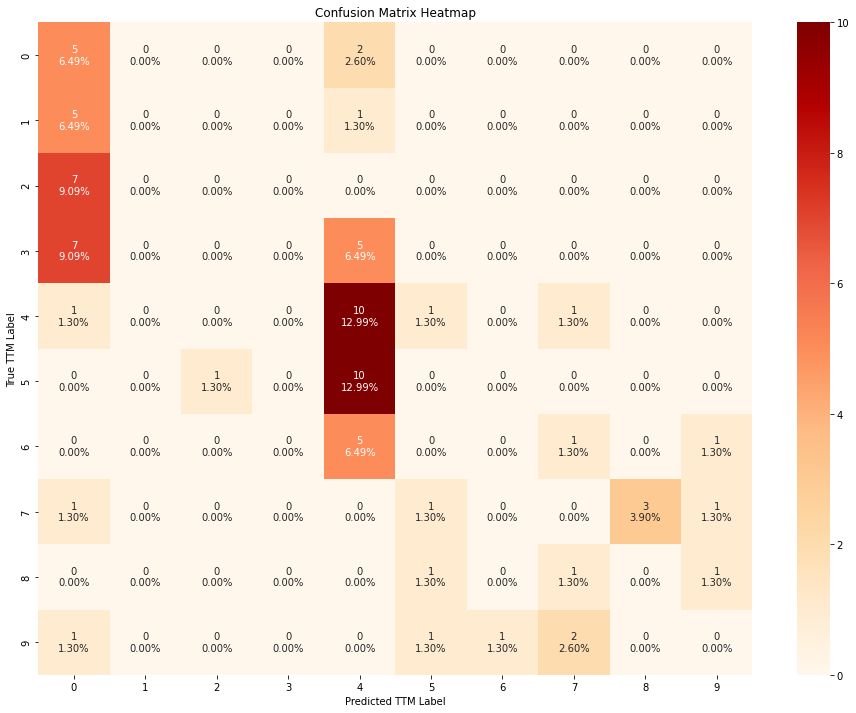

In [34]:
train_evaluate_classifier(gnb, X_train_scaled, y_train, X_test_scaled, y_test)

Accuracy : 0.2987012987012987


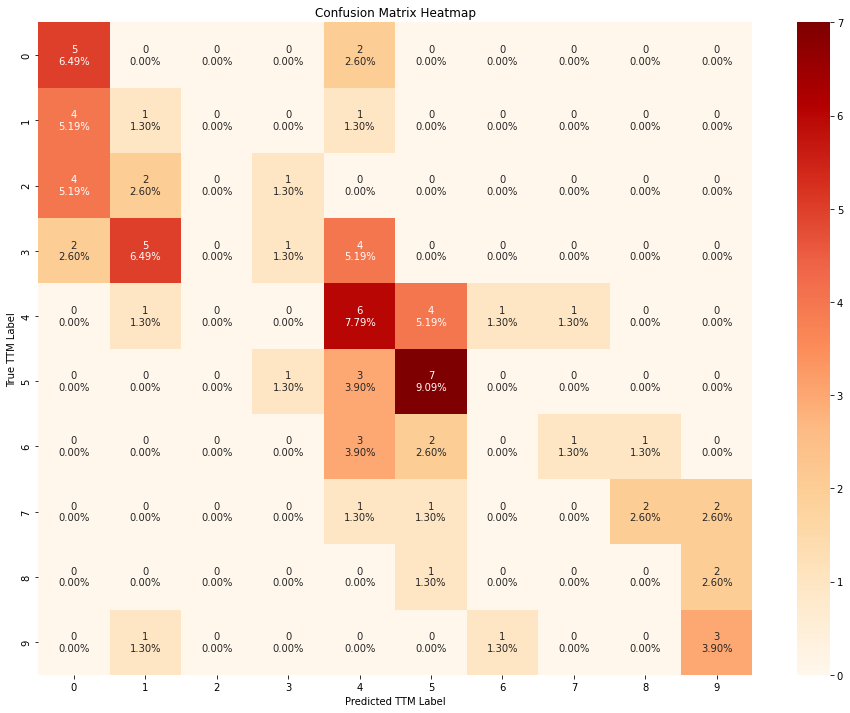

In [35]:
train_evaluate_classifier(svc, X_train_scaled, y_train, X_test_scaled, y_test)

Accuracy : 0.37662337662337664


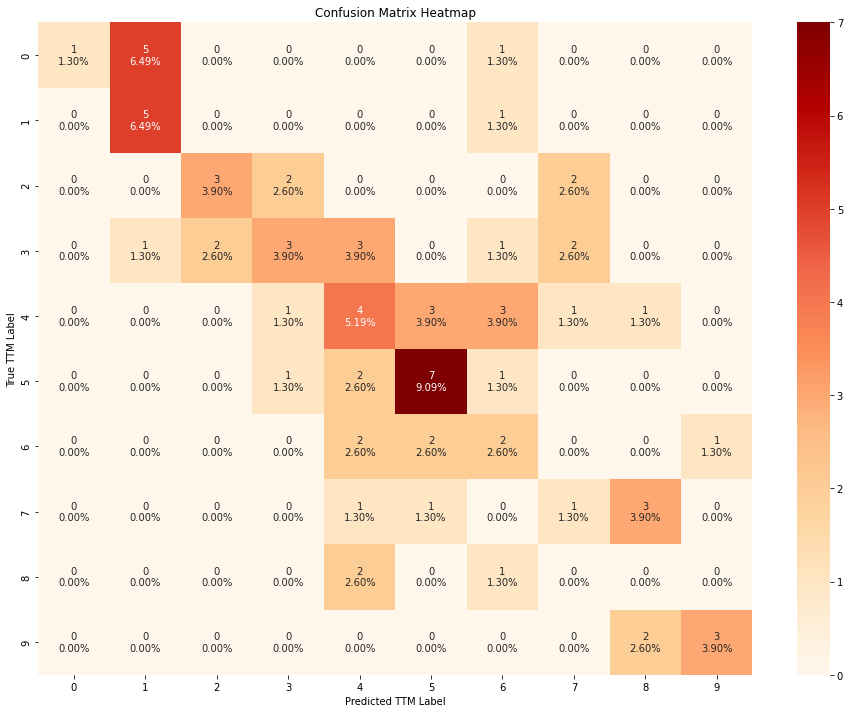

In [36]:
train_evaluate_classifier(rf, X_train_scaled, y_train, X_test_scaled, y_test)

Accuracy : 0.38961038961038963


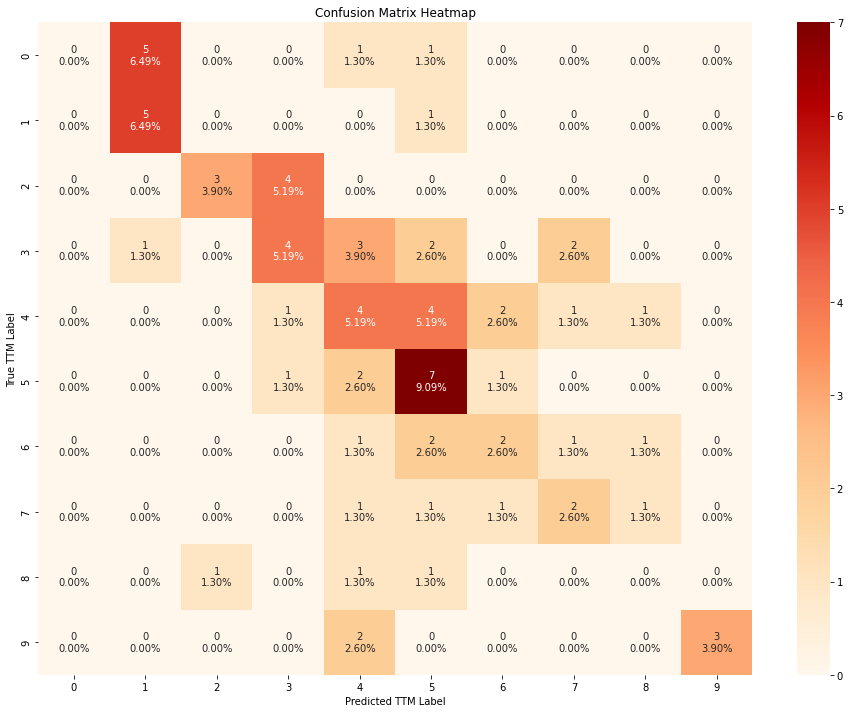

In [37]:
train_evaluate_classifier(xgbc, X_train_scaled, y_train, X_test_scaled, y_test)

In [38]:
dict_accuracy

{'GaussianNB': 0.19480519480519481,
 'SVC': 0.2987012987012987,
 'RandomForestClassifier': 0.37662337662337664,
 'XGBClassifier': 0.38961038961038963}

In [39]:
best_accuracy = max(dict_accuracy.values())

In [40]:
best_model = max(dict_accuracy, key = dict_accuracy.get)

In [41]:
best_model

'XGBClassifier'

Note that for model deployment (which is the eventual goal), we will also need to include any scaler or preprocessor objects. This is because the input to the inference service will be raw unscaled data. We plan to address this issue by using `sklearn.Pipeline` object to package the preprocessor(s) and model as one "combined" model. 

In the step below, we create a copy of the best performing model that is the Random Forest Classifier, so that we can save it to S3 later on and use it for model deployment.

From your explorations, if you wish to save another better performing model to the pipeline set `best_model` as one of rf, xgbc, svc or gnb

In [42]:
models = {"RandomForestClassifier": rf, "XGBClassifier": xgbc, "SVC": svc, "GaussianNB": gnb}

In [43]:
# create a clone (create a copy of the object with the learned weights)
selected_model = deepcopy(models[best_model])

In [44]:
# sanity check
print(classification_report(y_test, selected_model.predict(X_test_scaled)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.45      0.83      0.59         6
           2       0.75      0.43      0.55         7
           3       0.40      0.33      0.36        12
           4       0.27      0.31      0.29        13
           5       0.37      0.64      0.47        11
           6       0.33      0.29      0.31         7
           7       0.33      0.33      0.33         6
           8       0.00      0.00      0.00         3
           9       1.00      0.60      0.75         5

    accuracy                           0.39        77
   macro avg       0.39      0.38      0.36        77
weighted avg       0.38      0.39      0.37        77



## Create sklearn Pipeline

Here, we will create an sklearn pipeline consisting of 2 steps, scaling of the input features and the classifier itself. We will then save this Pipeline as a `model.joblib` file on S3 for serving the model pipeline using the Seldon Sklearn Server.

In [45]:
pipe = Pipeline(
    steps=[
        ("extract_features", raw_data_processor),
        ("scale", scaler),
        ("rf", selected_model),
    ]
)

## Write Model to S3

In [46]:
MODEL_KEY = os.path.join(s3_input_data_path, ORG, REPO, "ttm-model")
MODEL_FILENAME = "model.joblib"

s3_resource = boto3.resource(
    "s3",
    endpoint_url=s3_endpoint_url,
    aws_access_key_id=s3_access_key,
    aws_secret_access_key=s3_secret_key,
)

with tempfile.TemporaryFile() as fp:
    joblib.dump(pipe, fp)
    fp.seek(0)
    s3_obj = s3_resource.Object(s3_bucket, f"{MODEL_KEY}/{MODEL_FILENAME}")
    s3_obj.put(Body=fp.read())

In [47]:
## Sanity Check
buffer = BytesIO()
s3_object = s3_resource.Object(s3_bucket, f"{MODEL_KEY}/{MODEL_FILENAME}")
s3_object.download_fileobj(buffer)
model = joblib.load(buffer)
model

Pipeline(steps=[('extract_features',
                 ColumnTransformer(transformers=[('pr_size',
                                                  OrdinalEncoder(categories=[['XS',
                                                                              'S',
                                                                              'M',
                                                                              'L',
                                                                              'XL',
                                                                              'XXL']]),
                                                  ['size']),
                                                 ('created_at_details',
                                                  DateTimeDetailsTransformer(),
                                                  ['created_at']),
                                                 ('n_changed_files',
                                                  NumChangedFilesTransformer(),
                                                  ['changed_files_number']),
                                                 ('body_size',
                                                  StringLenTransformer(),
                                                  ['body']),
                                                 ('n_commits', 'p...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.1, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=125, n_jobs=-1, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto',
                               random_state=42, reg_alpha=0, ...))])

In [48]:
# take raw pr data and predict ttm classes
preds = model.predict(pr_df.reindex(X_test.index))
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.45      0.83      0.59         6
           2       0.75      0.43      0.55         7
           3       0.40      0.33      0.36        12
           4       0.27      0.31      0.29        13
           5       0.37      0.64      0.47        11
           6       0.33      0.29      0.31         7
           7       0.33      0.33      0.33         6
           8       0.00      0.00      0.00         3
           9       1.00      0.60      0.75         5

    accuracy                           0.39        77
   macro avg       0.39      0.38      0.36        77
weighted avg       0.38      0.39      0.37        77



In [49]:
# check all raw data files in s3
bucket = cc.s3_resource.Bucket(s3_bucket)
objects = [i for i in bucket.objects.all() if s3_input_data_path + "/" in i.key]
sorted(objects, key=lambda x: x.key)

[s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov4/srcopsmetrics/bot_knowledge/thoth-station/mi/PullRequest.json'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov4/thoth-station/mi/features/thoth-stationmiFILETYPE.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov4/thoth-station/mi/features/thoth-stationmititlewords.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov4/thoth-station/mi/test-data/X_test.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov4/thoth-station/mi/test-data/y_test.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov4/thoth-station/mi/ttm-model/model.joblib'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov4/thoth-station/mi/ttm_feature_engineered_dataset.parquet')]

## Conclusion

In this notebook, we explored various classifiers, namely, Naive Bayes, SVM, Random Forests, and XGBoost. 

## Next Step

We can run these notebooks in automation using Elyra and Kubeflow pipelines. As the immediate next step, we will to deploy the best model from this notebook as an inference service using Seldon.